Create a 10 x 10 grid graph, with 40% of nodes belonging to the pink party and 60% belonging to the purple party.

Generate a ReCom ensemble for partitions of the graph into 10 districts and keep track of seat share for each party.

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline  
import random
import time
import math
import os
import csv

import geopandas

from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.constraints.validity import within_percent_of_ideal_population
from gerrychain.metrics import mean_median,efficiency_gap
from gerrychain.proposals import recom
from functools import partial
from gerrychain.tree import recursive_tree_part

from tqdm import tqdm

ImportError: cannot import name 'Graph' from 'gerrychain' (unknown location)

In [8]:
n1 = 10  # Graph dimensions
n2 = 10
graph1=nx.grid_graph([n1, n2])

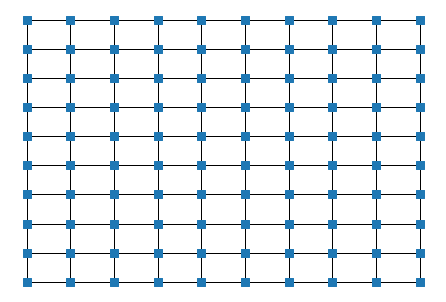

In [3]:
plt.figure()
nx.draw(graph1, pos = {x:x for x in graph1.nodes()}, node_size = 50, node_shape ='s')
plt.show()

Set each graph node's population equal to 1, assign 40% randomly to the pink party and 60% to the purple party, and identify which nodes are on the outer boundary of the graph:

In [7]:
for n in graph1.nodes():
    graph1.nodes[n]["population"]=1
    if random.random()<0.4:
        graph1.nodes[n]["pink"]=1
        graph1.nodes[n]["purple"]=0
    else:
        graph1.nodes[n]["pink"]=0
        graph1.nodes[n]["purple"]=1
    
    if 0 == n[0] or n2-1 == n[0] or 0 == n[1] or n1-1 == n[1]:
        graph1.nodes[n]["boundary_node"]=True
        if (0 == n[0] or n2-1 == n[0]) and (0 == n[1] or n1-1 == n[1]):
            graph1.nodes[n]["boundary_perim"]=2
        else:
            graph1.nodes[n]["boundary_perim"]=1
    else:
        graph1.nodes[n]["boundary_node"]=False


Plot the graph according to partisan affiliation of each node:

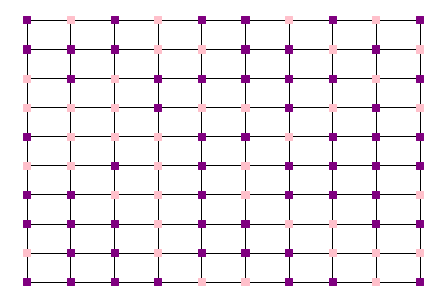

In [8]:
partycolorlist=["pink", "purple"]
party_cmap = matplotlib.colors.ListedColormap(partycolorlist)

plt.figure()
nx.draw(graph1, pos = {x:x for x in graph1.nodes()}, node_color = [graph1.nodes[x]["purple"] for x in graph1.nodes()] ,node_size = 50, node_shape ='s',cmap = party_cmap)
plt.show()

Build a simple initial partition into 10 districts. 

In [9]:
cddict = {x: int(10*x[0]/n2)  for x in graph1.nodes()}     

Plot initial partition, just for kicks:

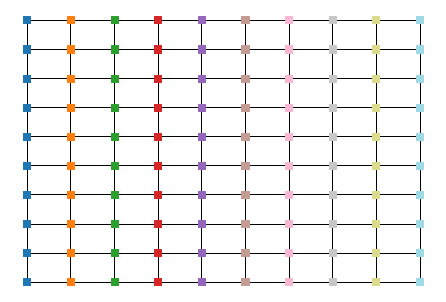

In [10]:
plt.figure()
nx.draw(graph1, pos = {x:x for x in graph1.nodes()}, node_color = [cddict[x] for x in graph1.nodes()] ,node_size = 50, node_shape ='s',cmap = 'tab20')
plt.show()

Define and configure updaters and a function to count votes in each district:

In [11]:
def pink_votes(graph):
    pvotes=0
    for n in graph.nodes():
        if graph.nodes[n]["pink"] > graph.nodes[n]["purple"]:
            pvotes += 1
    return(pvotes)
    

updaters = {'population': Tally('population')}


In [12]:
initial_partition = Partition(graph1,assignment=cddict,updaters=updaters)


Add constraints:

In [13]:
popbound=within_percent_of_ideal_population(initial_partition,.02)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)


Set up the ReCom proposal and define the chain:

In [14]:
tree_proposal = partial(recom,
                       pop_col="population",
                       pop_target=ideal_population,
                       epsilon=0.02,
                       node_repeats=1
                      )

recom_chain=MarkovChain(
    proposal=tree_proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, .02)
            ],
        accept=accept.always_accept,
        initial_state=initial_partition,
        total_steps=1000
        )


Define lists to keep track of statistics for each chain:

In [15]:
pink_seats=[]

Run chain, draw final districting plans in the chain, and collect stats

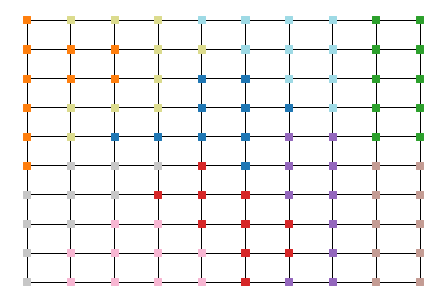

In [16]:
for partition in recom_chain.with_progress_bar():
    pinkseats=0
    for dist_num, subgraph in partition.subgraphs.items():
        if pink_votes(subgraph) > 5:
            pinkseats += 1
        elif pink_votes(subgraph)==5:
            pinkseats +=0.5
    pink_seats.append(pinkseats)


plt.figure()
nx.draw(graph1, pos = {x:x for x in graph1.nodes()}, node_color = [dict(partition.assignment)[x] for x in graph1.nodes()] ,node_size = 50, node_shape ='s',cmap = 'tab20')
plt.show()


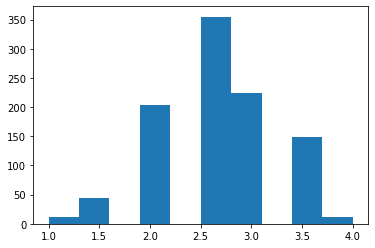

In [19]:
plt.hist(pink_seats)
plt.show()

Putting these into more intelligent bins:

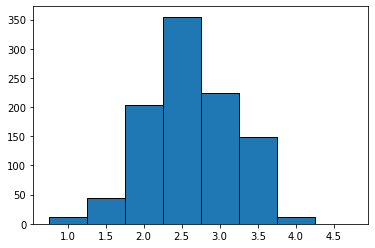

In [20]:
plt.hist(pink_seats, ec="black", bins=[0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75])
plt.show()

So the most common outcome is 2.5 seats for pink - not proportional!